In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
import os
import cv2

path = r"C:\Users\kezya_sxr\Downloads\mri\Training"
classes = {'no_tumor': 0, 'pituitary_tumor': 1}
X = []
Y = []

for cls in classes:
    pth = os.path.join(path, cls)
    for j in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, j), 0)
        img = cv2.resize(img, (200, 200))
        X.append(img)
        Y.append(classes[cls])

In [4]:
X = np.array(X)
Y = np.array(Y)

In [5]:
pd.Series(Y).value_counts()

1    827
0    395
Name: count, dtype: int64

In [6]:
X_updated = X.reshape(len(X), -1)

In [7]:
X.shape, X_updated.shape

((1222, 200, 200), (1222, 40000))

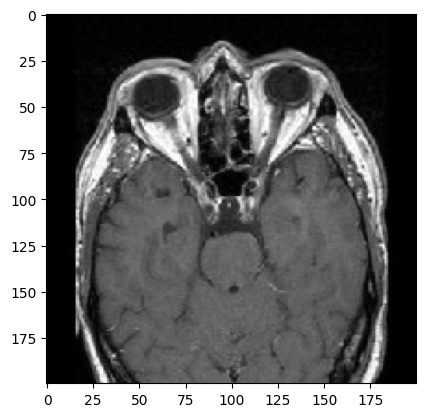

In [8]:
plt.imshow(X[0], cmap='gray')

## 1. Data Exploration and Visualization:
- Visualize the distribution of the three tumor classes in the dataset. Are the classes balanced or
imbalanced?
- Plot the distribution of patient ages in the dataset. Are there any trends or patterns related to
age and the presence of specific tumor types?

C:\Users\kezya_sxr\AppData\Local\Temp\ipykernel_21468\1512822905.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Class', palette='Set2')


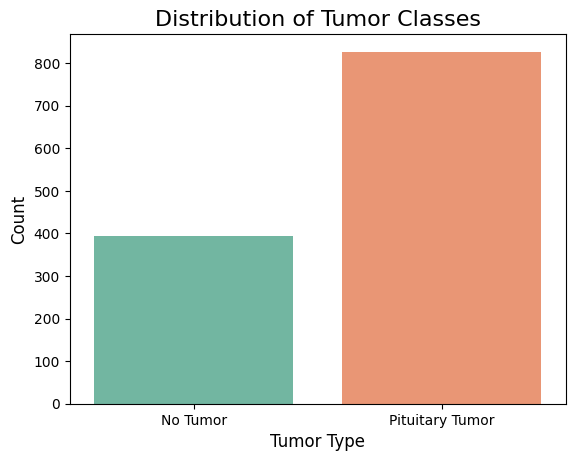

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.DataFrame(Y, columns=['Class'])
class_map = {0: 'No Tumor', 1: 'Pituitary Tumor'}
df['Class'] = df['Class'].map(class_map)
sns.countplot(data=df, x='Class', palette='Set2')
plt.title('Distribution of Tumor Classes', fontsize=16)
plt.xlabel('Tumor Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


## 2. Data Preprocessing:
- Split the dataset into training and testing sets (e.g., 80% training and 20% testing).
- Apply data augmentation techniques to increase the size of the training dataset. Visualize
some of the augmented images.

In [17]:
from sklearn.model_selection import train_test_split

# Splitting the dataset (80% training, 20% testing)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

print(f"Training data shape: {xtrain.shape}")
print(f"Testing data shape: {xtest.shape}")


Training data shape: (977, 200, 200)
Testing data shape: (245, 200, 200)


**Applying data augmentation**

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Reshape images to (200, 200, 1) to work with Keras
xtrain = xtrain.reshape(xtrain.shape[0], 200, 200, 1)
xtest = xtest.reshape(xtest.shape[0], 200, 200, 1)

# Create an ImageDataGenerator object for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotations
    width_shift_range=0.1,  # Random horizontal shifts
    height_shift_range=0.1, # Random vertical shifts
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flipping
    fill_mode='nearest'     # Filling strategy for transformed images
)

# Fit the generator on the training data
datagen.fit(xtrain)

# Create an augmented image generator for the training data
train_generator = datagen.flow(xtrain, ytrain, batch_size=32)


**Visualize augmented images**

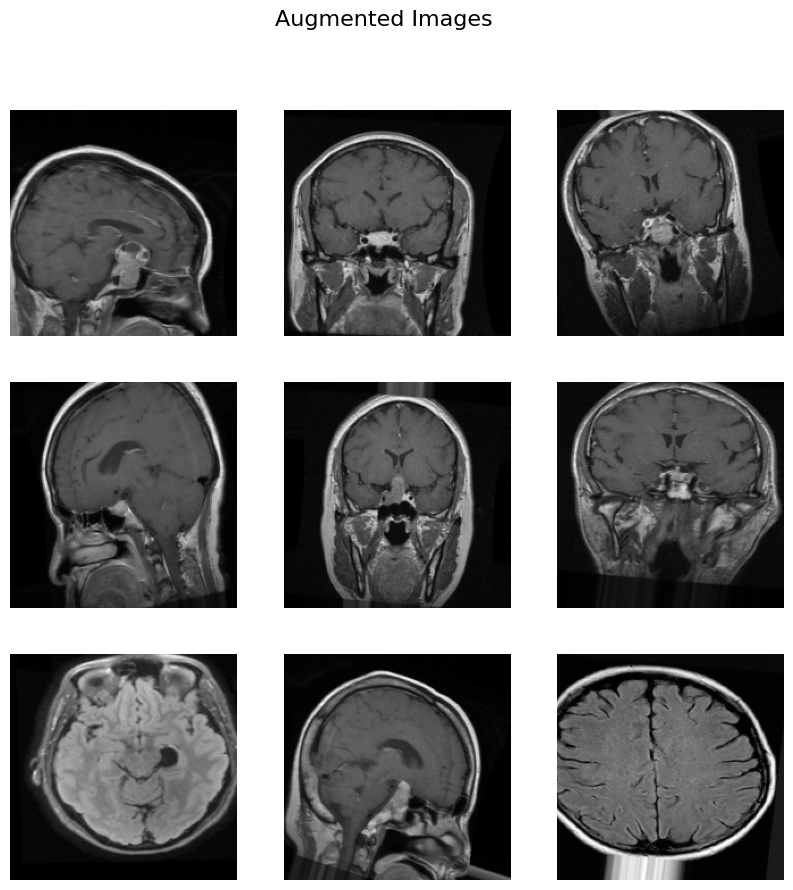

In [20]:

import matplotlib.pyplot as plt

# Get a batch of images from the generator
augmented_images, _ = next(train_generator)

# Plot some augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(200, 200), cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.show()


## 3. Model Building and Training:
- Extract relevant features from the MRI images. Visualize a few examples of these extracted
features.
- Train an SVM classifier on the training data for multiclass classification. Visualize the
decision boundaries of the SVM classifier along with the support vectors for each class.

**Extract features from MRI images**

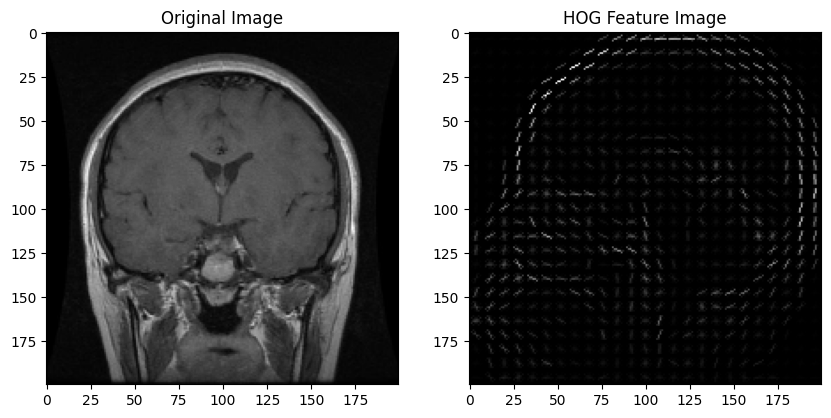

In [23]:
from skimage.feature import hog
import numpy as np

# Define a function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Extract HOG features for each image
        feature, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                                 cells_per_block=(2, 2), visualize=True)
        hog_features.append(feature)
    return np.array(hog_features), hog_image

# Extract HOG features for training data
xtrain_hog, hog_image = extract_hog_features(xtrain.reshape(-1, 200, 200))

# Visualize a few HOG feature images
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(xtrain[0].reshape(200, 200), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('HOG Feature Image')
plt.imshow(hog_image, cmap='gray')
plt.show()

# Extract HOG features for test data
xtest_hog, _ = extract_hog_features(xtest.reshape(-1, 200, 200))


- **Original Image:** Displays the image in its original grayscale form.
- **HOG Feature Image:** Shows the HOG features, highlighting the edges and directions of gradients that are captured by the HOG descriptor.

**Train the SVM classifier**

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train an SVM classifier
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(xtrain_hog, ytrain)

# Evaluate the classifier
train_acc = svm_model.score(xtrain_hog, ytrain)
test_acc = svm_model.score(xtest_hog, ytest)

print(f"Training Accuracy: {train_acc}")
print(f"Testing Accuracy: {test_acc}")


Training Accuracy: 1.0
Testing Accuracy: 0.9755102040816327


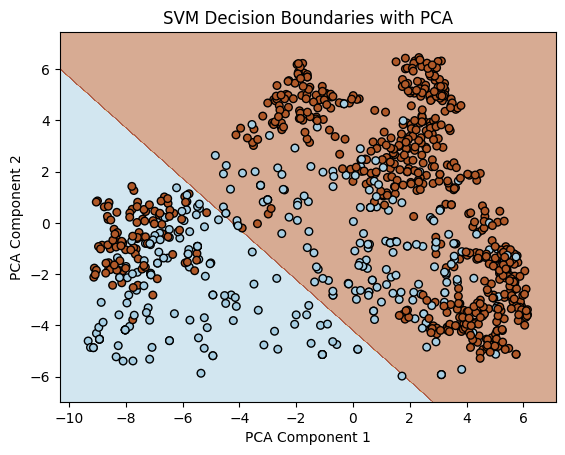

In [25]:
from sklearn.decomposition import PCA
import numpy as np

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
xtrain_pca = pca.fit_transform(xtrain_hog)
xtest_pca = pca.transform(xtest_hog)

# Train SVM on the reduced data (PCA-reduced features)
svm_pca_model = SVC(kernel='linear', C=1.0)
svm_pca_model.fit(xtrain_pca, ytrain)

# Plot decision boundaries
def plot_decision_boundaries(X, y, model):
    # Create a mesh grid
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the labels for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary and scatter points
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolor='k', cmap=plt.cm.Paired)
    plt.title("SVM Decision Boundaries with PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Visualize the decision boundaries on the training data
plot_decision_boundaries(xtrain_pca, ytrain, svm_pca_model)


**PCA Transformation**: The data has been reduced to two principal components, capturing the most variance and making it easier to visualize in 2D.

**SVM Decision Boundary:** A linear SVM classifier has been applied, resulting in a straight line that separates the two classes in the PCA-transformed space.

**Class Separation:** Most data points are correctly classified with minimal overlap, indicating the SVM is performing well in distinguishing the two classes.

**Linear Separability:** The clear linear boundary suggests that the classes are nearly linearly separable in this reduced-dimensional space.

**PCA Effectiveness:** PCA has effectively transformed the data into a space where the SVM can create a clear decision boundary, facilitating better visualization and classification

## 4. Model Evaluation:
- Evaluate the SVM model&#39;s performance using metrics such as accuracy, precision, recall, F1-
score, and ROC-AUC for each class. Visualize the confusion matrix.
- Plot the Receiver Operating Characteristic (ROC) curves for each class and calculate the Area
Under the Curve (AUC) to assess the model&#39;s discrimination ability.

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import numpy as np

# Predict the test data using the trained SVM
y_pred = svm_model.predict(xtest_hog)

# Accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (includes precision, recall, F1-score)
print("Classification Report:\n", classification_report(ytest, y_pred, target_names=['No Tumor', 'Pituitary Tumor']))

# Confusion matrix
conf_matrix = confusion_matrix(ytest, y_pred)


Accuracy: 0.9755
Classification Report:
                  precision    recall  f1-score   support

       No Tumor       0.99      0.94      0.96        79
Pituitary Tumor       0.97      0.99      0.98       166

       accuracy                           0.98       245
      macro avg       0.98      0.97      0.97       245
   weighted avg       0.98      0.98      0.98       245



Text(0.5, 1.0, 'Confusion Matrix')

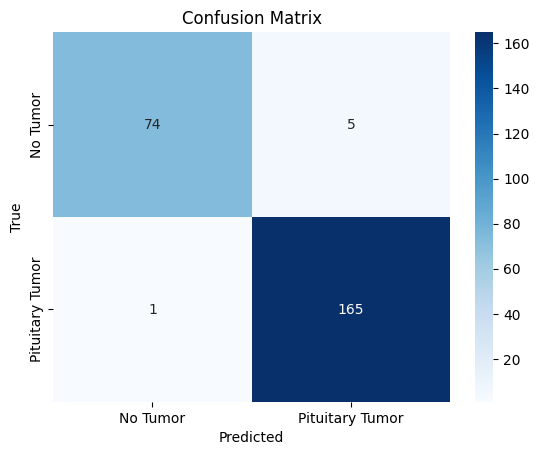

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Pituitary Tumor'], yticklabels=['No Tumor', 'Pituitary Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

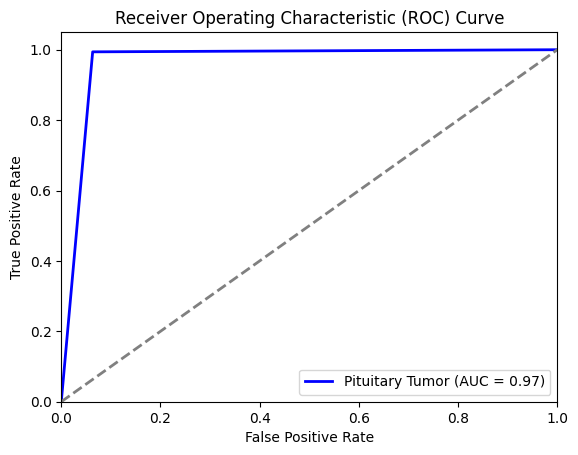

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Pituitary Tumor (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## 5. Hyperparameter Tuning:
- Experiment with different kernel functions (e.g., linear, polynomial, RBF) and SVM
hyperparameters. Visualize how changes in hyperparameters impact the model&#39;s performance.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np

# Define the SVM model
svm = SVC()

# Set up the hyperparameter grid
param_grid = {
    'C': [0.1],  # Regularization parameter
    'kernel': ['linear'],  # Kernel type
    'gamma': ['scale']  # Kernel coefficient (for poly and rbf)
}

# Set up GridSearchCV to search over the hyperparameter space
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(xtrain_hog, ytrain)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(xtest_hog, ytest)
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.9816
Test Accuracy with Best Hyperparameters: 0.9755


## 6.Model Interpretation:
- Determine the importance of extracted features in classifying the different tumor types.
Visualize the feature importances.

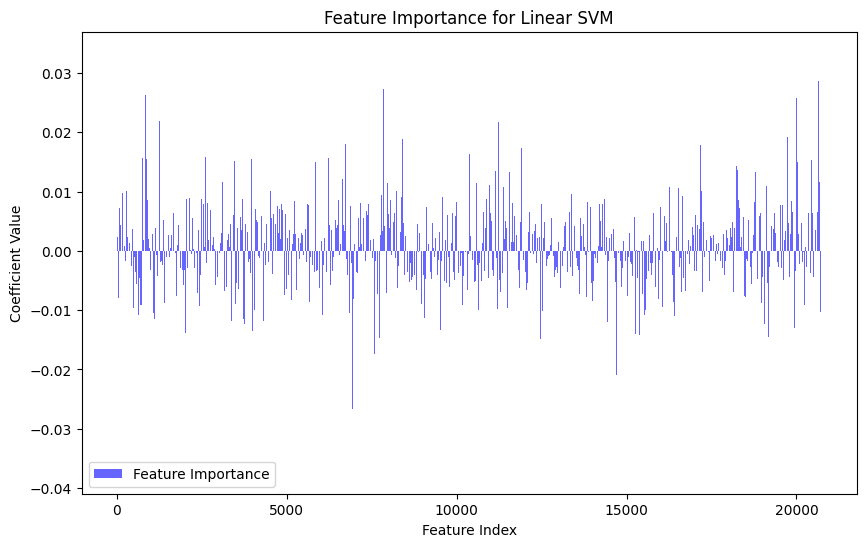

In [38]:
# Train a linear SVM classifier
linear_svm = SVC(kernel='linear')
linear_svm.fit(xtrain_hog, ytrain)

# Get the coefficients of the model (feature importance)
coef = linear_svm.coef_[0]  # Accessing only the coefficients for the first class

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(xtrain_hog.shape[1]), coef, color='b', alpha=0.6, label='Feature Importance')
plt.title('Feature Importance for Linear SVM')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()


In [39]:
!pip install shap

## 7. Prediction:
- Make predictions on the testing dataset and visualize some of the MRI images with their
predicted labels.
- Identify and visualize a few examples of misclassified MRI images. Explore common
patterns among these misclassifications.

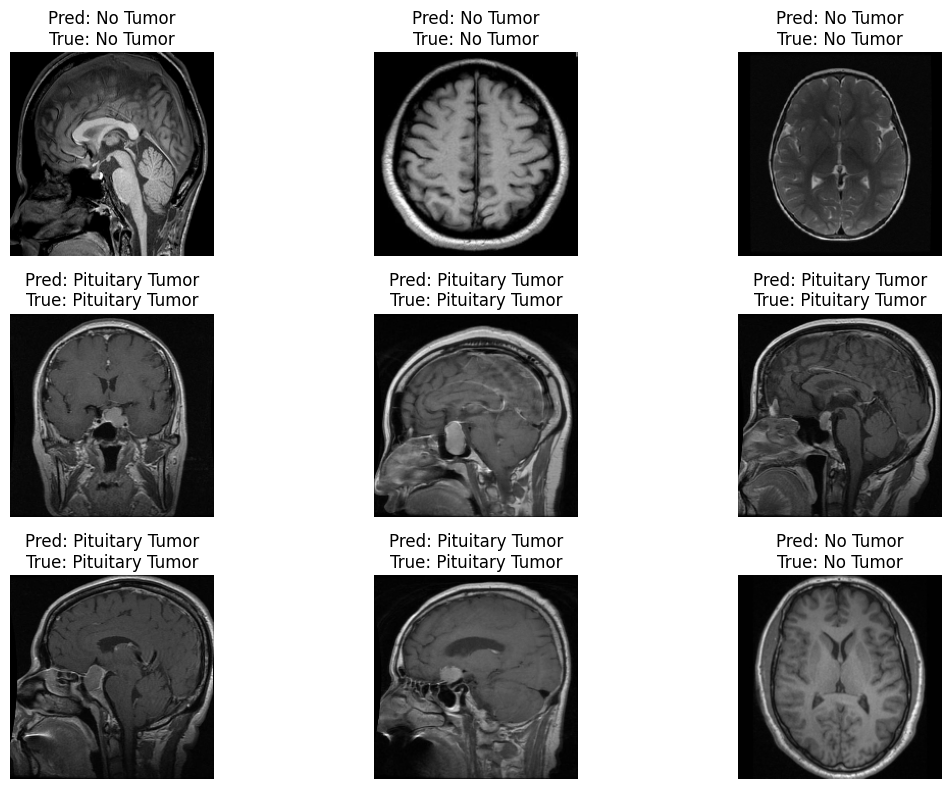

In [41]:
import matplotlib.pyplot as plt

# Make predictions on the testing dataset
y_pred = best_svm.predict(xtest_hog)

# Define a dictionary for decoding the predictions
dec = {0: 'No Tumor', 1: 'Pituitary Tumor'}

# Visualize a few MRI images with their predicted labels
plt.figure(figsize=(12, 8))
c = 1
for i in range(9):  # Display 9 images
    img = xtest[i].reshape(200, 200)  # Reshape back to the original image dimensions
    pred_label = y_pred[i]  # Predicted label
    true_label = ytest[i]  # True label
    
    plt.subplot(3, 3, c)
    plt.imshow(img, cmap='gray')
    plt.title(f'Pred: {dec[pred_label]}\nTrue: {dec[true_label]}')
    plt.axis('off')
    c += 1

plt.tight_layout()
plt.show()


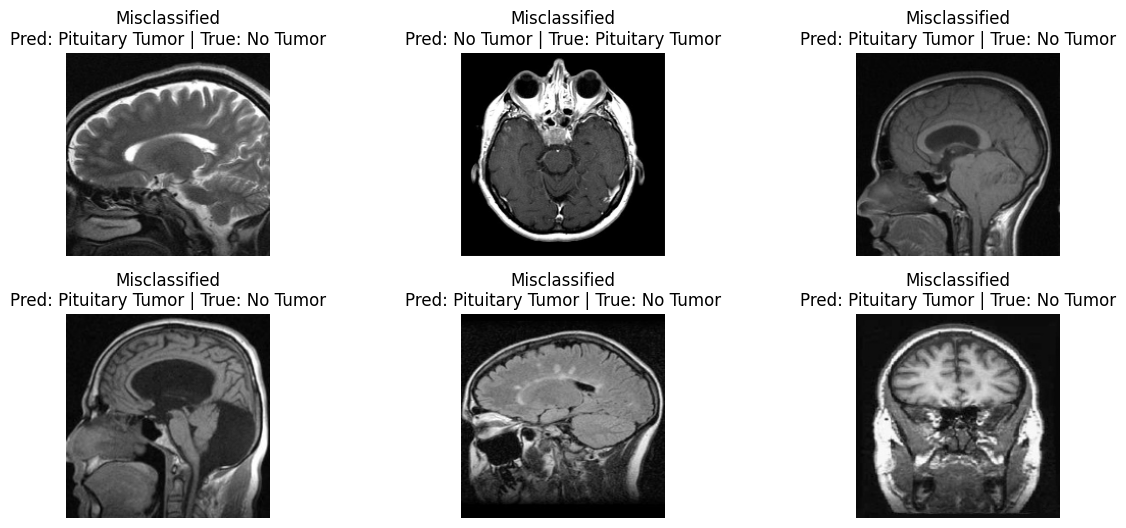

In [42]:
# Identify misclassified images
misclassified_indices = np.where(ytest != y_pred)[0]

# Visualize a few examples of misclassified images
plt.figure(figsize=(12, 8))
c = 1
for i in misclassified_indices[:9]:  # Display 9 misclassified images
    img = xtest[i].reshape(200, 200)  # Reshape back to the original image dimensions
    pred_label = y_pred[i]
    true_label = ytest[i]
    
    plt.subplot(3, 3, c)
    plt.imshow(img, cmap='gray')
    plt.title(f'Misclassified\nPred: {dec[pred_label]} | True: {dec[true_label]}')
    plt.axis('off')
    c += 1

plt.tight_layout()
plt.show()


In [43]:
# Count misclassifications for each true class
misclassified_counts = pd.Series(ytest[misclassified_indices]).value_counts()

# Print the misclassification counts for each class
print("Misclassifications per class:")
for label, count in misclassified_counts.items():
    print(f"{dec[label]}: {count}")


Misclassifications per class:
No Tumor: 5
Pituitary Tumor: 1
